In [1]:
import pandas as pd
import numpy as np
import scipy as sp
from scipy import stats

In [2]:
cancer =pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data',header=None, sep=",")
cancer.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
attribute_name = []
attribute_name.append("case_id")
attribute_name.append("type")

a = ['radius','texture','perimeter','area','smoothness','compactness',
     'concavity','concave points','symmetry','fractal dimension']

for i in range(0,10):
    b = "mean_" + a[i] 
    attribute_name.append(b)   
for i in range(0,10):
    b = "se_" + a[i]
    attribute_name.append(b)    
for i in range(0,10):
    b = "worst_" + a[i]
    attribute_name.append(b)

In [4]:
cancer.columns = attribute_name

In [5]:
X = cancer.iloc[:,2:]
y = cancer.iloc[:,1:2]

In [6]:
from sklearn.preprocessing import label_binarize
y = label_binarize(y, classes=['M', 'B'])

In [7]:
from sklearn.tree import DecisionTreeClassifier # A decision tree classifier
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score 
from sklearn.linear_model import LogisticRegression 
from sklearn import neighbors, datasets
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
np.random.seed(42)

In [8]:
inner_cv = KFold(n_splits=5, shuffle=True,random_state = 42) # for parameter optimization (validation)
outer_cv = KFold(n_splits=5, shuffle=True,random_state = 42) # generalization performance testing

## Decision tree

In [9]:
dt0 = DecisionTreeClassifier(random_state=42)
dt0.fit(X,y)
nested_score_gs = cross_val_score(dt0, X=X, y=y, cv=inner_cv,scoring='f1')
print("Nested CV Accuracy: ",nested_score_gs.mean(), " +/- ", nested_score_gs.std())

Nested CV Accuracy:  0.9465112726598186  +/-  0.013530194242190475


In [10]:
### first tuning

gs_dt = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                  param_grid=[{'max_depth': list(np.arange(1,20,3)),
                               'max_leaf_nodes': list(np.arange(10,30,3)),
                               'min_impurity_decrease': list(np.arange(0,0.011,0.002)),
                               'min_samples_leaf': list(np.arange(1,20,4)),
                               'criterion':['gini','entropy']}],
                  scoring='f1', 
                  cv=inner_cv,
                  n_jobs=4)

gs_dt = gs_dt.fit(X,y)

print("Non-nested CV Accuracy: ", gs_dt.best_score_)
print("Optimal Parameter: ", gs_dt.best_params_)
print("Optimal Estimator: ", gs_dt.best_estimator_)

Non-nested CV Accuracy:  0.9652153806922389
Optimal Parameter:  {'criterion': 'gini', 'max_depth': 4, 'max_leaf_nodes': 10, 'min_impurity_decrease': 0.008, 'min_samples_leaf': 5}
Optimal Estimator:  DecisionTreeClassifier(max_depth=4, max_leaf_nodes=10,
                       min_impurity_decrease=0.008, min_samples_leaf=5,
                       random_state=42)


In [13]:
nested_score_gs = cross_val_score(gs_dt, X=X, y=y, cv=outer_cv, scoring='f1')
print("Nested CV Accuracy: ",nested_score_gs.mean(), " +/- ", nested_score_gs.std())

Nested CV Accuracy:  0.9564276902786156  +/-  0.01441826587754457


In [15]:
### second tuning

gs_dt1 = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                  param_grid=[{'max_depth': [3,4,5,6],
                               'max_leaf_nodes':list(np.arange(7,13,1)),
                               'min_impurity_decrease': list(np.arange(0.005,0.011,0.001)),
                               'min_samples_leaf': list(np.arange(1,7,1)),
                               'criterion':['gini']}],
                  scoring='f1', 
                  cv=inner_cv,
                  n_jobs=4)

gs_dt1 = gs_dt1.fit(X,y)
print("Non-nested CV Accuracy: ", gs_dt1.best_score_)
print("Optimal Parameter: ", gs_dt1.best_params_)
print("Optimal Estimator: ", gs_dt1.best_estimator_)

Non-nested CV Accuracy:  0.9652153806922389
Optimal Parameter:  {'criterion': 'gini', 'max_depth': 4, 'max_leaf_nodes': 8, 'min_impurity_decrease': 0.005, 'min_samples_leaf': 6}
Optimal Estimator:  DecisionTreeClassifier(max_depth=4, max_leaf_nodes=8,
                       min_impurity_decrease=0.005, min_samples_leaf=6,
                       random_state=42)


In [16]:
nested_score_gs = cross_val_score(gs_dt1, X=X, y=y, cv=outer_cv, scoring='f1')
print("Nested CV Accuracy: ",nested_score_gs.mean(), " +/- ", nested_score_gs.std())

Nested CV Accuracy:  0.9611778590740722  +/-  0.00848425934558384


In [18]:
results1 = pd.DataFrame(gs_dt1.cv_results_)
results1.sort_values(by='rank_test_score', inplace=True)
results1.head(50)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_leaf_nodes,param_min_impurity_decrease,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
335,0.013915,0.001468,0.004919,0.001068,gini,4,10,0.006,6,"{'criterion': 'gini', 'max_depth': 4, 'max_lea...",0.965035,0.980645,0.951049,0.958333,0.971014,0.965215,0.010196,1
340,0.014406,0.001471,0.007229,0.002207,gini,4,10,0.007,5,"{'criterion': 'gini', 'max_depth': 4, 'max_lea...",0.965035,0.980645,0.951049,0.958333,0.971014,0.965215,0.010196,1
484,0.009829,0.000677,0.003941,0.000897,gini,5,8,0.007,5,"{'criterion': 'gini', 'max_depth': 5, 'max_lea...",0.965035,0.980645,0.951049,0.958333,0.971014,0.965215,0.010196,1
767,0.012130,0.001365,0.005339,0.000747,gini,6,10,0.006,6,"{'criterion': 'gini', 'max_depth': 6, 'max_lea...",0.965035,0.980645,0.951049,0.958333,0.971014,0.965215,0.010196,1
813,0.013940,0.001449,0.005824,0.000883,gini,6,11,0.008,4,"{'criterion': 'gini', 'max_depth': 6, 'max_lea...",0.965035,0.980645,0.951049,0.958333,0.971014,0.965215,0.010196,1
814,0.012188,0.001842,0.005053,0.001456,gini,6,11,0.008,5,"{'criterion': 'gini', 'max_depth': 6, 'max_lea...",0.965035,0.980645,0.951049,0.958333,0.971014,0.965215,0.010196,1
329,0.011015,0.001125,0.004486,0.000915,gini,4,10,0.005,6,"{'criterion': 'gini', 'max_depth': 4, 'max_lea...",0.965035,0.980645,0.951049,0.958333,0.971014,0.965215,0.010196,1
489,0.010959,0.001594,0.004097,0.001088,gini,5,8,0.008,4,"{'criterion': 'gini', 'max_depth': 5, 'max_lea...",0.965035,0.980645,0.951049,0.958333,0.971014,0.965215,0.010196,1
490,0.009896,0.000421,0.003715,0.000926,gini,5,8,0.008,5,"{'criterion': 'gini', 'max_depth': 5, 'max_lea...",0.965035,0.980645,0.951049,0.958333,0.971014,0.965215,0.010196,1
310,0.010486,0.001597,0.004129,0.000766,gini,4,9,0.008,5,"{'criterion': 'gini', 'max_depth': 4, 'max_lea...",0.965035,0.980645,0.951049,0.958333,0.971014,0.965215,0.010196,1


### the table above shows that there are actually many sets of param achive the highest score 0.965215
### so I further plot some of them to see if these sets of param fit the same tree

DecisionTreeClassifier(max_depth=4, max_leaf_nodes=8,
                       min_impurity_decrease=0.005, min_samples_leaf=6,
                       random_state=42)


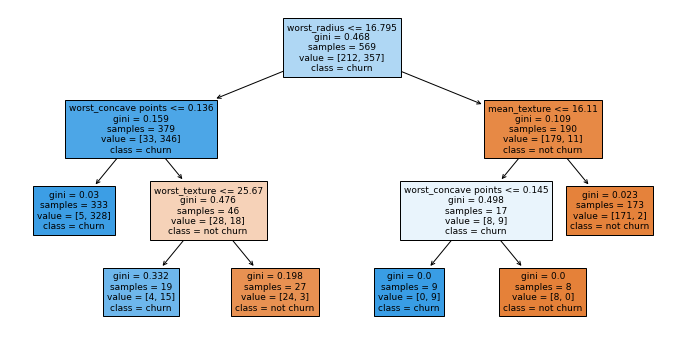

In [33]:
import matplotlib.pyplot as plt
from sklearn import tree

# plot the best tree
plt.figure(figsize=(12,6))  
tree.plot_tree(gs_dt1.best_estimator_, fontsize=9,feature_names = list(X.columns), 
               class_names = ['not churn','churn'],filled = True)
print(gs_dt1.best_estimator_)
plt.show()

DecisionTreeClassifier(max_depth=3, max_leaf_nodes=7,
                       min_impurity_decrease=0.005, min_samples_leaf=2,
                       random_state=42)


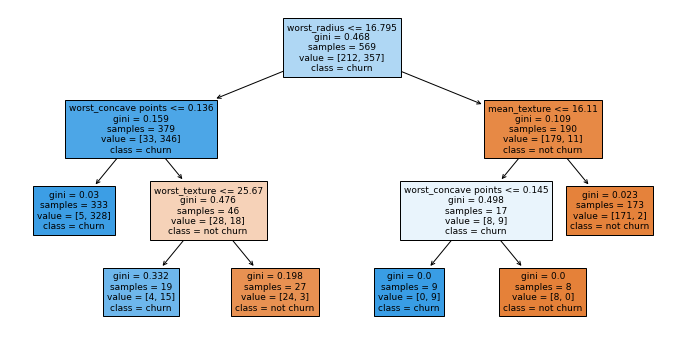

In [34]:
params_2nd_best = results1.loc[1, 'params']
dt_2nd_best = gs_dt.best_estimator_.set_params(**params_2nd_best)
plt.figure(figsize=(12,6))  
tree.plot_tree(dt_2nd_best, fontsize=9,feature_names = list(X.columns), 
               class_names = ['not churn','churn'],filled = True)
print(dt_2nd_best)
plt.show()

DecisionTreeClassifier(max_depth=3, max_leaf_nodes=7,
                       min_impurity_decrease=0.006, min_samples_leaf=4,
                       random_state=42)


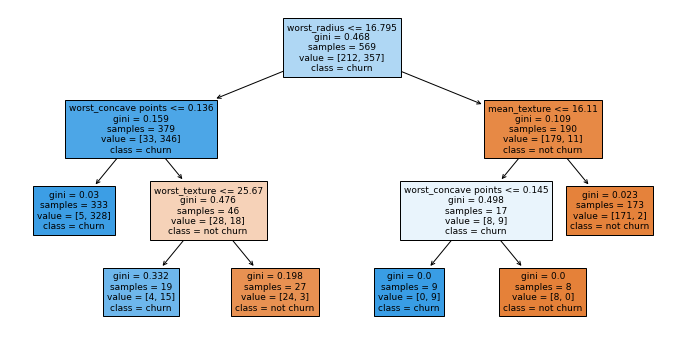

In [35]:
params_10th_best = results1.loc[9, 'params']
dt_10th_best = gs_dt.best_estimator_.set_params(**params_10th_best)
plt.figure(figsize=(12,6))  
tree.plot_tree(dt_10th_best, fontsize=9,feature_names = list(X.columns), 
               class_names = ['not churn','churn'],filled = True)
print(dt_10th_best)
plt.show()

### so these different sets of params in fact train a same tree
### so the best param can be any of these sets
### here I take {'criterion': 'gini', 'max_depth': 4, 'max_leaf_nodes': 8, 'min_impurity_decrease': 0.005, 'min_samples_leaf': 6}

## KNN

In [36]:
#Normalize Data
pipe = Pipeline([
        ('sc', StandardScaler()),     
        ('knn', neighbors.KNeighborsClassifier(metric='minkowski')) ])

params = {'knn__n_neighbors': list(np.arange(1,20,1)),
          'knn__weights': ['uniform', 'distance'],
          'knn__p': [1,2]}

gs_knn = GridSearchCV(estimator=pipe,
                  param_grid=params,
                  scoring='f1',
                  cv=inner_cv,
                  n_jobs=4)

gs_knn = gs_knn.fit(X,y.ravel()) 
print("Non-nested CV Accuracy: ", gs_knn.best_score_)
print("Optimal Parameter: ", gs_knn.best_params_)
print("Optimal Estimator: ", gs_knn.best_estimator_)

Non-nested CV Accuracy:  0.9733536293846626
Optimal Parameter:  {'knn__n_neighbors': 4, 'knn__p': 2, 'knn__weights': 'uniform'}
Optimal Estimator:  Pipeline(steps=[('sc', StandardScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=4))])


In [37]:
nested_score_gs_knn = cross_val_score(gs_knn, X=X, y=y.ravel(), cv=outer_cv)
print("Nested CV Accuracy: ",nested_score_gs_knn.mean(), " +/- ", nested_score_gs_knn.std())

Nested CV Accuracy:  0.9718555740758898  +/-  0.017710867112369553


## Logistics

In [38]:
from  warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

gs_lr = GridSearchCV(estimator=LogisticRegression(random_state=42, solver='liblinear'),
                  param_grid=[{'C': [ 0.00001, 0.0001, 0.001, 0.01, 0.1 ,1 ,10 ,100, 1000, 10000, 100000, 1000000],
                               'penalty':['l1','l2'],
                               'fit_intercept':['True','False']}],
                  scoring='f1',
                  cv=inner_cv,
                  n_jobs=4)

gs_lr = gs_lr.fit(X,y.ravel())

print("Non-nested CV Accuracy: ", gs_lr.best_score_)
print("Optimal Parameter: ", gs_lr.best_params_)
print("Optimal Estimator: ", gs_lr.best_estimator_)
nested_score_gs_lr = cross_val_score(gs_lr, X=X, y=y.ravel(), cv=outer_cv)
print("Nested CV Accuracy:",nested_score_gs_lr.mean(), " +/- ", nested_score_gs_lr.std())

Non-nested CV Accuracy:  0.9745578262603946
Optimal Parameter:  {'C': 100, 'fit_intercept': 'True', 'penalty': 'l1'}
Optimal Estimator:  LogisticRegression(C=100, fit_intercept='True', penalty='l1', random_state=42,
                   solver='liblinear')
Nested CV Accuracy: 0.9644316663845094  +/-  0.02064710003725082


In [39]:
gs_lr1 = GridSearchCV(estimator=LogisticRegression(random_state=42, solver='liblinear'),
                  param_grid=[{'C': list(np.arange(50,500,50)), # binary search
                               'penalty':['l1'], # Lasso
                               'fit_intercept':['True']}],
                  scoring='f1',
                  cv=inner_cv,
                  n_jobs=4)

gs_lr1 = gs_lr1.fit(X,y.ravel())

print("Non-nested CV Accuracy: ", gs_lr1.best_score_)
print("Optimal Parameter: ", gs_lr1.best_params_)
print("Optimal Estimator: ", gs_lr1.best_estimator_)
nested_score_gs_lr1 = cross_val_score(gs_lr1, X=X, y=y.ravel(), cv=outer_cv)
print("Nested CV Accuracy:",nested_score_gs_lr1.mean(), " +/- ", nested_score_gs_lr1.std())

Non-nested CV Accuracy:  0.9800047700974315
Optimal Parameter:  {'C': 50, 'fit_intercept': 'True', 'penalty': 'l1'}
Optimal Estimator:  LogisticRegression(C=50, fit_intercept='True', penalty='l1', random_state=42,
                   solver='liblinear')
Nested CV Accuracy: 0.9772269923196536  +/-  0.01604727867288254


In [40]:
gs_lr1 = GridSearchCV(estimator=LogisticRegression(random_state=42, solver='liblinear'),
                  param_grid=[{'C': list(np.arange(25,75,5)), # binary search
                               'penalty':['l1'], # Lasso
                               'fit_intercept':['True']}],
                  scoring='f1',
                  cv=inner_cv,
                  n_jobs=4)

gs_lr1 = gs_lr1.fit(X,y.ravel())

print("Non-nested CV Accuracy: ", gs_lr1.best_score_)
print("Optimal Parameter: ", gs_lr1.best_params_)
print("Optimal Estimator: ", gs_lr1.best_estimator_)
nested_score_gs_lr1 = cross_val_score(gs_lr1, X=X, y=y.ravel(), cv=outer_cv)
print("Nested CV Accuracy:",nested_score_gs_lr1.mean(), " +/- ", nested_score_gs_lr1.std())

Non-nested CV Accuracy:  0.9800047700974315
Optimal Parameter:  {'C': 45, 'fit_intercept': 'True', 'penalty': 'l1'}
Optimal Estimator:  LogisticRegression(C=45, fit_intercept='True', penalty='l1', random_state=42,
                   solver='liblinear')
Nested CV Accuracy: 0.9786446168407263  +/-  0.015854463734583935


In [41]:
gs_lr2 = GridSearchCV(estimator=LogisticRegression(random_state=42, solver='liblinear'),
                  param_grid=[{'C': list(np.arange(41,59,1)),
                               'penalty':['l1'], # Lasso
                               'fit_intercept':['True']}],
                  scoring='f1',
                  cv=inner_cv,
                  n_jobs=4)

gs_lr2 = gs_lr2.fit(X,y.ravel())

print("Non-nested CV Accuracy: ", gs_lr2.best_score_)
print("Optimal Parameter: ", gs_lr2.best_params_)
print("Optimal Estimator: ", gs_lr2.best_estimator_)
nested_score_gs_lr2 = cross_val_score(gs_lr2, X=X, y=y.ravel(), cv=outer_cv)
print("Nested CV Accuracy:",nested_score_gs_lr2.mean(), " +/- ", nested_score_gs_lr2.std())

Non-nested CV Accuracy:  0.9800047700974315
Optimal Parameter:  {'C': 42, 'fit_intercept': 'True', 'penalty': 'l1'}
Optimal Estimator:  LogisticRegression(C=42, fit_intercept='True', penalty='l1', random_state=42,
                   solver='liblinear')
Nested CV Accuracy: 0.9800047700974315  +/-  0.016142337873336444


In [42]:
results_lr2 = pd.DataFrame(gs_lr2.cv_results_)
results_lr2.sort_values(by='rank_test_score', inplace=True)
results_lr2.head(20) # C can be 42-56

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_fit_intercept,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
8,0.741694,0.491918,0.004039,0.000893,49,True,l1,"{'C': 49, 'fit_intercept': 'True', 'penalty': ...",0.985915,0.986842,0.986111,0.993007,0.948148,0.980005,0.016142,1
1,0.669280,0.361158,0.004362,0.001431,42,True,l1,"{'C': 42, 'fit_intercept': 'True', 'penalty': ...",0.985915,0.986842,0.986111,0.993007,0.948148,0.980005,0.016142,1
2,0.696964,0.317000,0.004721,0.000666,43,True,l1,"{'C': 43, 'fit_intercept': 'True', 'penalty': ...",0.985915,0.986842,0.986111,0.993007,0.948148,0.980005,0.016142,1
3,0.697781,0.313153,0.003729,0.000472,44,True,l1,"{'C': 44, 'fit_intercept': 'True', 'penalty': ...",0.985915,0.986842,0.986111,0.993007,0.948148,0.980005,0.016142,1
4,0.759294,0.381985,0.003339,0.000529,45,True,l1,"{'C': 45, 'fit_intercept': 'True', 'penalty': ...",0.985915,0.986842,0.986111,0.993007,0.948148,0.980005,0.016142,1
5,0.644111,0.323003,0.003816,0.000618,46,True,l1,"{'C': 46, 'fit_intercept': 'True', 'penalty': ...",0.985915,0.986842,0.986111,0.993007,0.948148,0.980005,0.016142,1
6,0.776312,0.481462,0.003341,0.000194,47,True,l1,"{'C': 47, 'fit_intercept': 'True', 'penalty': ...",0.985915,0.986842,0.986111,0.993007,0.948148,0.980005,0.016142,1
7,0.860923,0.422261,0.004095,0.000567,48,True,l1,"{'C': 48, 'fit_intercept': 'True', 'penalty': ...",0.985915,0.986842,0.986111,0.993007,0.948148,0.980005,0.016142,1
15,0.972114,0.570308,0.004846,0.001317,56,True,l1,"{'C': 56, 'fit_intercept': 'True', 'penalty': ...",0.985915,0.986842,0.986111,0.993007,0.948148,0.980005,0.016142,1
9,1.014324,0.477123,0.008737,0.008107,50,True,l1,"{'C': 50, 'fit_intercept': 'True', 'penalty': ...",0.985915,0.986842,0.986111,0.993007,0.948148,0.980005,0.016142,1


### from the table, in fact any C between 42-56 can give the highest score
### here I use {'C': 45, 'fit_intercept': 'True', 'penalty': 'l1'}

## Learning Curve

In [43]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):

    plt.figure()                    #display figure
    plt.title(title)
    if ylim is not None:            #if ylim was specified as an input, make sure the plots use these limits
        plt.ylim(*ylim)
    plt.xlabel("Training examples") #y label title
    plt.ylabel("Score")             #x label title
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
    train_scores_mean = np.mean(train_scores, axis=1) # Compute the arithmetic mean along the specified axis.
    train_scores_std = np.std(train_scores, axis=1)   # Compute the standard deviation along the specified axis.
    test_scores_mean = np.mean(test_scores, axis=1)   # Compute the arithmetic mean along the specified axis.
    test_scores_std = np.std(test_scores, axis=1)     # Compute the standard deviation along the specified axis.

    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r") # train data performance indicated with red
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g") # test data performance indicated with green

    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best") 
    return plt             

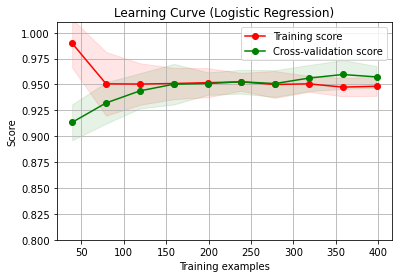

In [44]:
from sklearn.model_selection import learning_curve 
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt

title = "Learning Curve (Logistic Regression)"
cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=42)
estimator = LogisticRegression() 
plot_learning_curve(estimator, title, X, y, (0.8, 1.01), cv=cv, n_jobs=4, train_sizes=np.linspace(.1, 1.0, 10))

plt.show()

## Fitting Graph

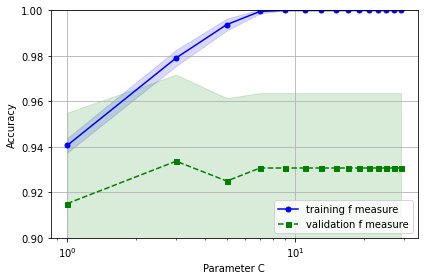

In [45]:
from sklearn.model_selection import validation_curve
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

param_range = list(np.arange(1,30,2))

train_scores, test_scores = validation_curve( 
                estimator=DecisionTreeClassifier(random_state=42), 
                X=X_train, 
                y=y_train, 
                param_name="max_depth", 
                param_range=param_range,
                cv=10,    
                scoring="f1", 
                n_jobs=4)

train_mean = np.mean(train_scores, axis=1) 
train_std = np.std(train_scores, axis=1)  
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, color='blue', marker='o', 
         markersize=5, label='training f measure')
plt.fill_between(param_range, train_mean + train_std,train_mean - train_std, alpha=0.15,color='blue')

plt.plot(param_range, test_mean,  color='green', linestyle='--', 
         marker='s', markersize=5,  label='validation f measure')
plt.fill_between(param_range, test_mean + test_std,test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.9, 1.0])
plt.tight_layout()
plt.show()          

10-fold cross validation:

ROC AUC: 0.99 (+/- 0.01) [Logistic regression]
ROC AUC: 0.96 (+/- 0.03) [Decision tree]
ROC AUC: 0.98 (+/- 0.02) [kNN]


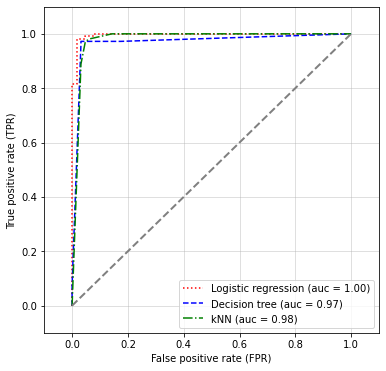

In [54]:
### ROC

from sklearn.metrics import roc_curve
from sklearn.metrics import auc

clf1 =  gs_lr1.best_estimator_
clf2 =  gs_dt1.best_estimator_
clf3 =  Pipeline([
        ('sc', StandardScaler()),     
        ('knn', gs_knn.best_estimator_)])

clf_labels = ['Logistic regression', 'Decision tree', 'kNN']
all_clf = [clf1, clf2, clf3]

print('10-fold cross validation:\n')
for clf, label in zip([clf1, clf2, clf3], clf_labels): #For all classifiers 
    if clf==clf1:
        y=y.ravel()
    scores = cross_val_score(estimator=clf, 
                             X=X,
                             y=y,
                             cv=10,
                             scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

colors = [ 'red', 'blue', 'green'] 
linestyles = [':', '--', '-.', '-'] 

plt.figure(figsize=(6,6))  
for clf, label, clr, ls in zip(all_clf,
               clf_labels, colors, linestyles):
    if clf==clf1:
        y_train=y_train.ravel()
        
    y_pred = clf.fit(X_train,
                     y_train).predict_proba(X_test)[:, 1] # Make predictions based on the classifiers
    fpr, tpr, thresholds = roc_curve(y_true=y_test, # Build ROC curve
                                     y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)                # Compute Area Under the Curve (AUC) 
    plt.plot(fpr, tpr,                         # Plot ROC Curve and create label with AUC values
             color=clr,
             linestyle=ls,
             label='%s (auc = %0.2f)' % (label, roc_auc))

plt.legend(loc='lower right')    # Where to place the legend
plt.plot([0, 1], [0, 1], # Visualize random classifier
         linestyle='--',
         color='gray',
         linewidth=2)

plt.xlim([-0.1, 1.1])   #limits for x axis
plt.ylim([-0.1, 1.1])   #limits for y axis
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')

plt.show()